# **Tutorial Objectives**
During the first week of the course, you learend about types of climate data from measurements, proxies and models, and computational tools for assessing past, present and future climate variability recorded by this data. During day one of this week, you began to explore climate model data from Earth System Models (ESMs) simulations conducted for the recent Climate Model Intercomparison Project (CMIP6) that are presented in the report from the Intergovernmental Panel on Climate Changes (IPCC). In addition to understanding the physical basis of the climate variations projected by these models, it's also important to assess the current and future socioeconomic impact of such climate change.  This day's tutorials focus on the socioeconomic projections regarding the future of climate change and is centered around the shared socioeconomic pathways framework used by the IPCC.

In this first tutorial, you will learn about the relationship between physical climate and socio-economic models, and their role in guiding our responses to climate change. This tutorial will provide insights into the pressing socioeconomic issues related to climate change, such as resource scarcity, population dynamics, and the potential impacts of unchecked resource extraction. You will explore the Integrated Assessment Modelling (IAM) used in IPCC projections, and the influence of shared socio-economic pathways on these projections. You will also utilise the `World3` model, a tool developed in the 1970s to analyze potential economic and population scenarios, to learn about nonlinear, coupled dynamics of various aggregated world system variables and how this model can be adapted to understand modern day climate challenges.

# **Setup**



In [1]:
# !pip install pyworld3

In [1]:
# imports
from IPython.display import Math
from IPython.display import display, HTML, Image
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from ipywidgets import interact
import ipywidgets as widgets
import pooch
import urllib
from pyworld3 import World3
from pyworld3.utils import plot_world_variables

In [2]:
# @title Figure settings
import ipywidgets as widgets       # interactive display
%config InlineBackend.figure_format = 'retina'
plt.style.use("https://raw.githubusercontent.com/ClimateMatchAcademy/course-content/main/cma.mplstyle")

sns.set_style("ticks", {'axes.grid': False})
%matplotlib inline
display(HTML("<style>.container { width:100% !important; }</style>"))
params = {'lines.linewidth': '3'}
plt.rcParams.update(params)

In [5]:
# @title Helper functions

def get_IPCC_data(var_name, path):
    IAMdf = pd.read_excel(path)
    IAMdf.drop(IAMdf.tail(2).index,inplace = True)  # excel file has 2 trailing rows of notes
    IAMdf.drop(['Model','Region','Variable','Unit','Notes'],axis=1,inplace =True) #remove columns we won't need

    # The data is in wideform (years are columns).
    # Longform (year of each datum as a column) is more convenient.
    # To collapse it to longform we'll use the `pd.wide_to_long` method that requires the following reformatting
    IAMdf.rename(columns=dict(zip(IAMdf.columns[1:],[var_name+str(y) for y in IAMdf.columns[1:]])),inplace=True) #add 'pop' to the year columns to tell the method which columns to map
    IAMdf.index = IAMdf.index.set_names(['id']) #name index
    IAMdf=IAMdf.reset_index() #make index a column
    IAMdf=pd.wide_to_long(IAMdf, [var_name], i='id', j="year")

    IAMdf=IAMdf.reset_index().drop('id',axis=1) #do some post mapping renaming
    IAMdf.year=IAMdf.year.apply(int) #turn year data from string to int
    if var_name=='pop':
        IAMdf[var_name]=1e6*IAMdf[var_name] #pop is in millions
    elif var_name=='CO2':
        IAMdf[var_name]=1e6*IAMdf[var_name] #CO2 is in Mt CO2/yr
    elif var_name=='forcing':
        IAMdf=IAMdf # forcing in W/m2
    return IAMdf

def run_and_plot(world3, nri_factor=1, new_lifetime_industrial_capital=14):
    # nonrenewable resources initial [resource units]
    world3.init_world3_constants(
        nri=nri_factor*1e12, alic1=14, alic2=new_lifetime_industrial_capital)
    world3.init_world3_variables()
    world3.set_world3_table_functions()
    world3.set_world3_delay_functions()
    world3.run_world3(fast=False)

    # select model variables to plot
    variables = [world3.nrfr, world3.iopc, world3.fpc,
                 world3.pop, world3.ppolx, world3.d, world3.cdr]
    variable_labels = ["Resource",  # nonrenewable resource fraction remaining (NRFR)
                       "Industry", # industrial output per capita [dollars/person-year] (IOPC)
                       "Food", # food production per capita [vegetable-equivalent kilograms/person-year] (FPC)
                       "Population",  # population [persons] (POP)
                       "Pollution",  # index of persistent pollution (PPOLX)
                                # (fraction of peristent pollution in 1970 = 1.36e8 pollution units)
                       "Deaths",
                       "Deathrate\n/1000"]
    variable_limits = [[0, 1], [0, 1e3], [0, 1e3], [
        0, 16e9], [0, 32], [0, 5e8], [0, 250]]  # y axis ranges

    plot_world_variables(world3.time, variables, variable_labels, variable_limits,
                         img_background=None,  # ./img/fig7-7.png",
                         figsize=[4+len(variables), 7],
                         title="initial non-renewable resources=" + \
                         str(nri_factor)+"*1e12",
                         grid=True)

    # overlay an SSP projection
    scenario_name='SSP2-Baseline'
    pop_path = pooch.retrieve('https://osf.io/download/ed9aq/',known_hash=None)
    IAMpopdf=get_IPCC_data('pop', pop_path)
    year_data = IAMpopdf.loc[IAMpopdf.Scenario==scenario_name,'year']
    var_data = IAMpopdf.loc[IAMpopdf.Scenario==scenario_name,'pop']
    axs = plt.gcf().axes
    axs[variable_labels.index('Population')].plot(year_data,var_data, 'r--', label=scenario_name)
    axs[variable_labels.index('Population')].legend(frameon=False)

In [3]:
# @title Video 1: Title
#Tech team will add code to format and display the video

# **Section 1: Exploring the IPCC's Socioeconomic Scenarios**

In this, and subsequent, tutorials, you will explore Integrated Assessment Models (IAMs) which are the standard class of models used to make climate change projections. IAMs couple a climate model to an economic model, allowing us to evaluate the two-way coupling between economic productivity and climate change severity. IAMs can also account for changes that result from mitigation efforts, which lessen anthropogenic emissions. In other words, IAMs are models that incorporate the economic impacts of climate change. 

Let's start by investigating some IAM model output, which will prepare you to explore `World3` (which gives similar socioeconomic output) later in this tutorial.

All data from the main simulations of the IAMs used in the IPCC reports is freely available for viewing [here](https://tntcat.iiasa.ac.at/SspDb/dsd). The simulations are labeled by the socioeconomic pathway (SSP1, SSP2, SSP3, SSP4, and SSP5) and the forcing level (greenhouse gas forcing of 2.6, 7.0, 8.5 W m<sup>2</sup> etc. by 2100). 

In previous days, you have lookd at climate model data for projections of sea surface temperature change under different SSPs. We saw that applying different greenhouse gas forcings to a climate model affects global temperature projections and also influences other parts of the climate system, such as precipitation. In this tutorial, we will begin to explore the socio-economic impacts associated with such changes to the physical climate system.

It is possible to download the IAM data if you provide an email address, but for this tutorial the following files have already been downloaded:

- Climate forcing
- World population
- Total CO<sub>2</sub> emissions

Since the files all have the same name, `iamc_db.xlsx`, we have added '_forcing', '_pop', and '_CO2' to differentiate the files. 

Let's load and plot this data to explore the forcing, population and CO<sub>2</sub> emissions across the different SSP scenarios. You can utilize the pre-defined plotting function from above.

SHA256 hash of downloaded file: 6cb9ecdcc8cd89e6b2c6438ed0f60a9afe4791e6fc4190b3a190da32242897a0
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.
/Users/jennapearson/anaconda3/envs/climatematch/lib/python3.10/site-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
SHA256 hash of downloaded file: 8ebe2fb8e0085e4382ff49dc1a68c6aca619d4490a0c8853c75c0d2e6db621e3
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.
/Users/jennapearson/anaconda3/envs/climatematch/lib/python3.10/site-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
SHA2

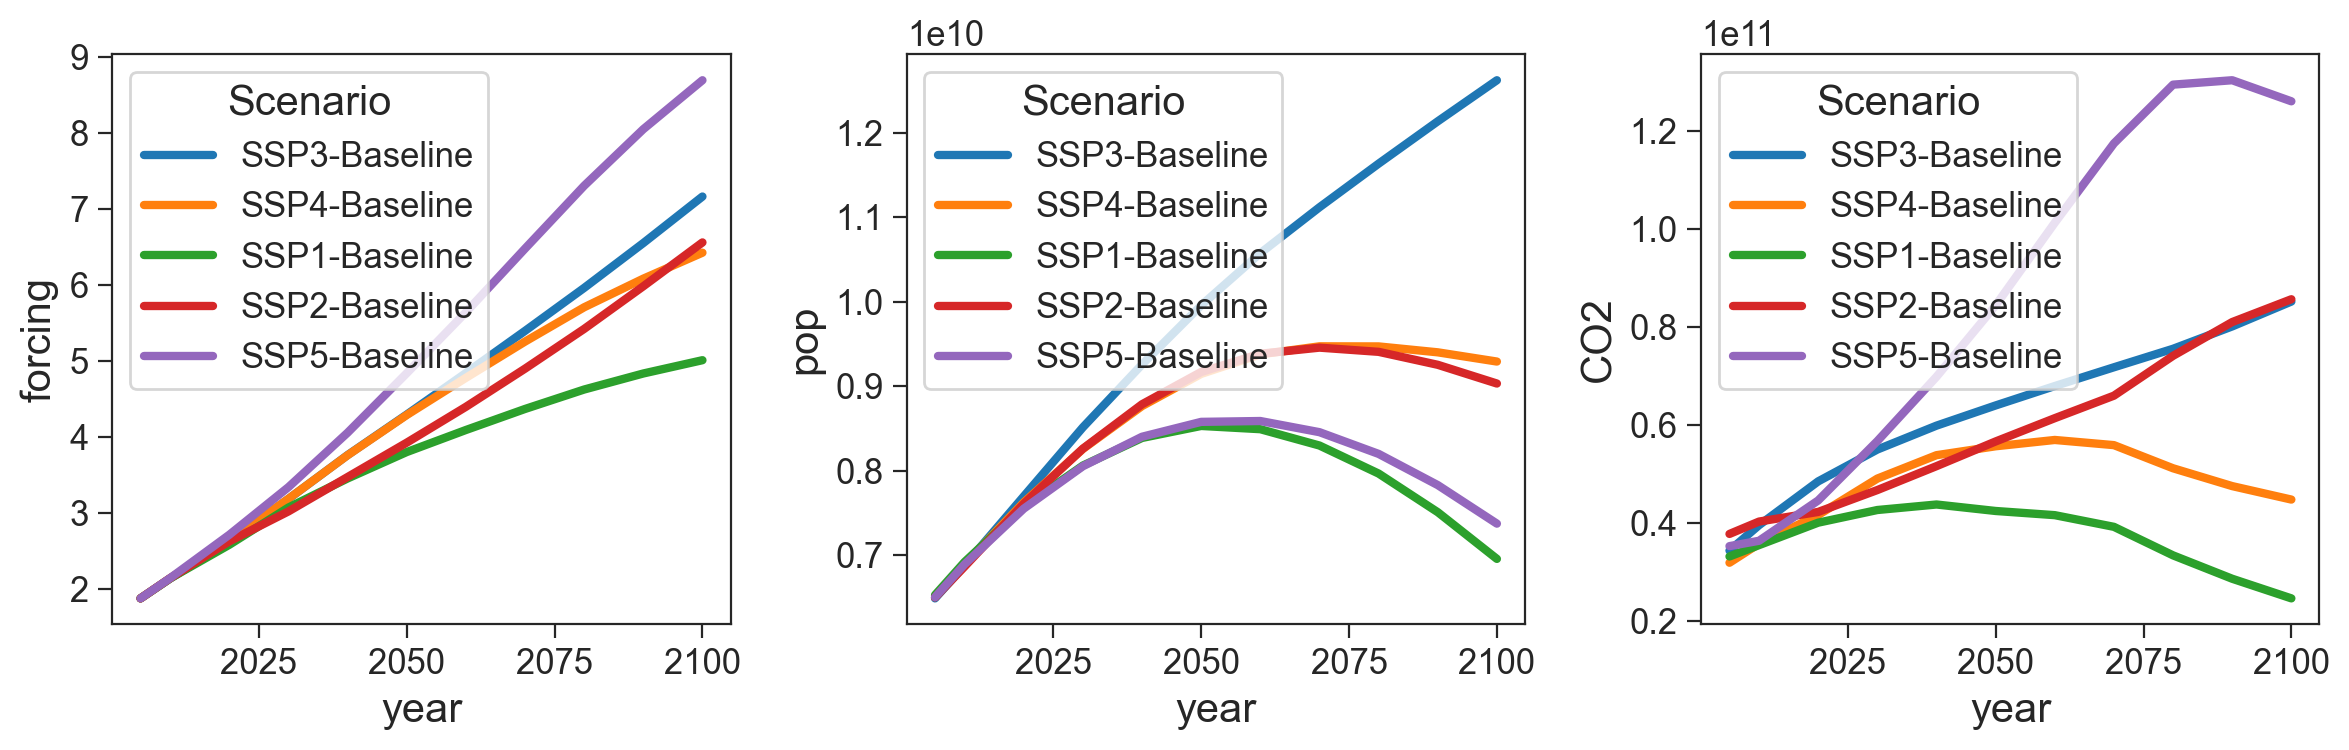

In [6]:
var_names = ['forcing','pop','CO2']
paths = ['https://osf.io/download/tkrf7/', 'https://osf.io/download/ed9aq/','https://osf.io/download/gcb79/']
axis_size=4
fig,ax=plt.subplots(1,len(var_names),figsize=(axis_size*len(var_names),axis_size))
for ax_idx,var_name in enumerate(var_names):
    path = pooch.retrieve(paths[ax_idx],known_hash=None)
    data_df=get_IPCC_data(var_name, path)
    sns.lineplot(ax=ax[ax_idx],data=data_df,x='year',y=var_name,hue='Scenario') # plot the data

The projections in the plots you just created show changes in climate forcing (left), population (middle) and CO<sub>2</sub> emissions (right) across the five different SSP scenarios, which are each represented by a distinct color in each plot.

The projections for each SSP are created by imposing the temperature changes that result from different levels of greenhouse gas forcing into a socioeconomic model component. This ensures the amount of emissions produced is consistent with the forcing for that particular scenario. In other words, the projected temperature change under different scenarios is used as a forcing for a socioeconomic model component in order to assess the socioeconomic impacts resulting from the temperature change associated with each SSP.

Not every variable in IAMs is endogenous (i.e. determined by other variables in the model). Some variables, like population or technology growth, are exogeneous (i.e. variables that are given to the model). In this case, population and economic growth, are derived from simple growth models. 

### **Question 1**

1. Having watched the video on the limits of growth, why might the continued growth in both population and economy not be assured?

In [1]:
# to_remove explanation
"""
1. The population growth is projected to decline and the human population is projected to stabilize towards the end of the century, as the consumption of resources continues to grow.
An economy based on growth-oriented extraction of a finite resource will collapse once it exhausts consumable resources.
""";

'\n1. The population growth is projected to decline and the human population is projected to stabilize towards the end of the century, as the consumption of resources continues to grow.\nAn economy based on growth-oriented extraction of a finite resource will collapse once it exhausts consumable resources.\n'

# **Section 2: World Models and `World3`**
In this section you will take a step back from IAMs and use another model class, *world models*, to first explore how socioeconomic system variables like population, capital and pollution co-evolve. You've already seen world models in the video for this tutorial, but let's recap what they are and why they are interesting.


World models are computational models that incorporate natural physical limits in the economy. For example, world models can help to assess the impact of an economy based on growth-oriented extraction of a finite resource. All variables in world model are endogeneous. Recall that endogeneous variables determined by other variables in the model, rather than being given to the model. Therefore, world models are self-contained and simply run as a dynamical system if given an initial condition and equations describing rates of change of the variables. The important variables in a world model are similar to those of Integrated Assessment Models: capital, production, population, pollution etc. 

`World3` is a world model that was developed in the 1970s and doesn't have an explicit climate component (perhaps its developers were unaware of climate change at the time, as many were back then). However, `World3` does have a *pollution* variable that is driven by industrial activity, and this pollution negatively impacts food production and directly increases mortality rates via health effects. If we were developing `World3` today with our knowledge of human-driven climate change, we would add greenhouse gas emissions as a component of the pollution variable, which is the place in `World3` representing the damaging waste of our industrial activity.  

The reason we are looking at `World3` here in this first tutorial, is that:
1. `World3` is an instructive world model of the resource depletion and pollution problem. It is essential to understand the forcings, feedbacks and results associated with these problems because they directly contribute to climate change. More specifically, understanding these problems helps us understand the socioeconomic forces driving the emissions that are the source of the climate change problem.
2. World models provide an alternative modelling tradition not steeped in the neoclassical economics on which IAMs are based. This provides some diversity in perspective.

*Note: the model in `World3` is not only wrong (i.e. missing many variables), but is a poor idealization. In other words, the `World3` model is not necessarily qualitatively predictive because it is missing some determining variables/model features (e.g. technology innovation/adaptation). It is thus almost certainly not predictive, but is still useful for thinking about 'world systems' because it includes important relationships between some key natural and socio-economic variables that we will look at here. In later tutorials, we will also critique elements of IAMs (e.g. for lacking important variables).*

## **Section 2.1: A Complete Map of `World3`**

Now that we have a basic understanding of World3, we can start to explore some more specific components and interactions of the model. 

Welcome to World3! Here is a stock-flow diagram of the full model:

In [6]:
display(Image(url="https://osf.io/download/hzrsn/", width=1000, unconfined=True))
# copyrighted image from the textbook:
# Meadows, D.L.; Behrens, W.W.; Meadows, D.L.; Naill, R.F.; Randers, J.; Zahn, E.K.O. The Dynamics of Growth in a Finite World; Wright-Allen Press: Cambridge, MA, USA, 1974.
# Source: https://www.mdpi.com/sustainability/sustainability-07-09864/article_deploy/html/images/sustainability-07-09864-g001.png
# Alternate image from the precursor model: Jay Forrester's world dynamic model: https://petterholdotme.files.wordpress.com/2022/04/world-dynamics.png

### **Question 2.1**
1. Increase the width of this image to 3000. 
2. Scroll around the larger image you just created to see what words you find in the node labels of the different parts of the model. Identify a category label within each quadrant of the model.

In [ ]:
#################################################
## TODO for students: details of what they should do ##
# Fill out function and remove
raise NotImplementedError("1. Increase the width of this image to 3000.")
#################################################

display(Image(url="https://osf.io/download/hzrsn/", width=3000, unconfined=True))

In [ ]:
# to_remove solution
display(Image(url="https://osf.io/download/hzrsn/", width=3000, unconfined=True))

In [1]:
# to_remove explanation
"""
1. upper-left example: population

upper-right example: pollution

bottom-left example: industrial output

bottom-right example: food per capita
""";

## **Section 2.2: A Sub-region of the Map of `World3`**

Here is a reduced diagram containing only some major variables in the model and their couplings:

In [9]:
display(Image(url="https://osf.io/download/h3mj2/", width=250))
#modified from another copyrighted image from Limits To Growth (1972, page 97)

This image can be used to follow a *pathway* describing the flow of model variable dependencies, to gain insight into how the model works. This is a similar concept to feedbacks (changes in one part of the system or forcing can cause changes in another). Recall from W1D1 that there are two types of feedbacks: positives feedbacks (change in variable A causes a change in variable B, which in turn causes a change in variable A in the same direction as the initial change) and negative feedbaks (change in variable A causes a change in variable B, which in turn causes a change in variable A in the opposite direction as the initial change). 

Let's explore some pathways and feedbacks described by this image: 
- Increased investment causes industrial capital to grow 
    - Increased industrial capital produces increased industrial output
    - Increased industrial output generates increased pollution and agricultural capital
    - Increased pollution and agricultural capital, along with cultivated land, generate more food
- Increased pollution and decreased food per capita cause increased mortality 
    - Increased mortality causes a decrease in population due to more deaths per year

There is a clear and intricate web of dependencies between these various factors. Changes in one area, such as industrial investment, can have cascading effects through this system, ultimately influencing population size, health, and wellbeing. This underscores the interconnected nature of socio-economic systems and the environment.

### **Questions 2.2**
Based on the model variable dependancy pathway described above and in the image, can you describe a: 
1. *Positive* feedback loop? 
2. *Negative* feedback loop? 

In [2]:
# to_remove explanation
"""
1. Positive Feedback Loop - Larger populations could produce greater investment, particularly if a significant portion of the population is engaged in productive labor. This, in turn, would boost industrial capital, resulting in more food which can sustain a larger population.
2. Negative Feedback Loop - Pollution and Agricultural Output: High levels of pollution can degrade the quality of land and water resources needed for agriculture, leading to reduced food production. This reduced agricultural output might spur efforts to limit industrial pollution, creating a negative feedback loop.
""";


# **Section 3: Working with `pyworld3`**

In this section you will use a `python` implementation of the `World3` called `pyworld3`. This model is openly accessible [here](https://github.com/cvanwynsberghe/pyworld3).

We have pre-defined a plotting function that also runs `pyworld3`, that you will use in this section. The plotting function has two inputs: 
- **nri_factor**: the initial amount of non-renewable resources. For example, this could include coal, natural gas and oil.
- **new_lifetime_industrial_capital**: a perturbed value of the lifetime of industrial capital to which the system will be perturbed at the perturbation year. For example, this variable could be used to represent a transition from fossil fuel-burning
power plants to lower-emitting technologies.
 
In addition, you need to set the end year of the simulations you wish to conduct. In this example, you should stop the simulations at 2100, which is also when most IPCC Earth System Model projections end.

In [10]:
maxyear = 2100

In this section, you will use `pyworld3` to assess changes associated with three different scenarios:
1. **Business-As-Usual (BAU)**: assumes continued growth based on historical trends, minimal mitigation, and specified amount of non-renewable resources 
2. **Abundant Resources (BAU3)**: same as BAU but with triple the amount of initial non-renewable resources 
3. **BAU3 with Active Cap on Production**: same as BAU3 but a step decrease in the lifetime of industrial capital, by imposing a reduction from 14 to 8 years in 2025.

For each scenario, you will plot and assess changes in multiple variables:
- **Death rate**: number of deather per 1000 people
- **Deaths**: number of deaths
- **Pollution**: index of persistent pollution (fraction of peristent pollution in 1970 = 1.36e8 pollution units)
- **Population**: population (people)
- **Food**: food production per capita (vegetable-equivalent kilograms/person-year)
- **Industry**: industrial output per capita (dollars/person-year)
- **Resource**: nonrenewable resource fraction remaining

## **Section 3.1: Original (Business-As-Usual - *BAU*) Scenario**

The Business-As-Usual (*BAU*) scenario assumes continued growth based on historical trends, alongside minimal mitigation. In this scenario there is specified amount of accessible, remaining non-renewable resources (normalized to 1 in the plots).

/srv/conda/envs/notebook/lib/python3.10/site-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


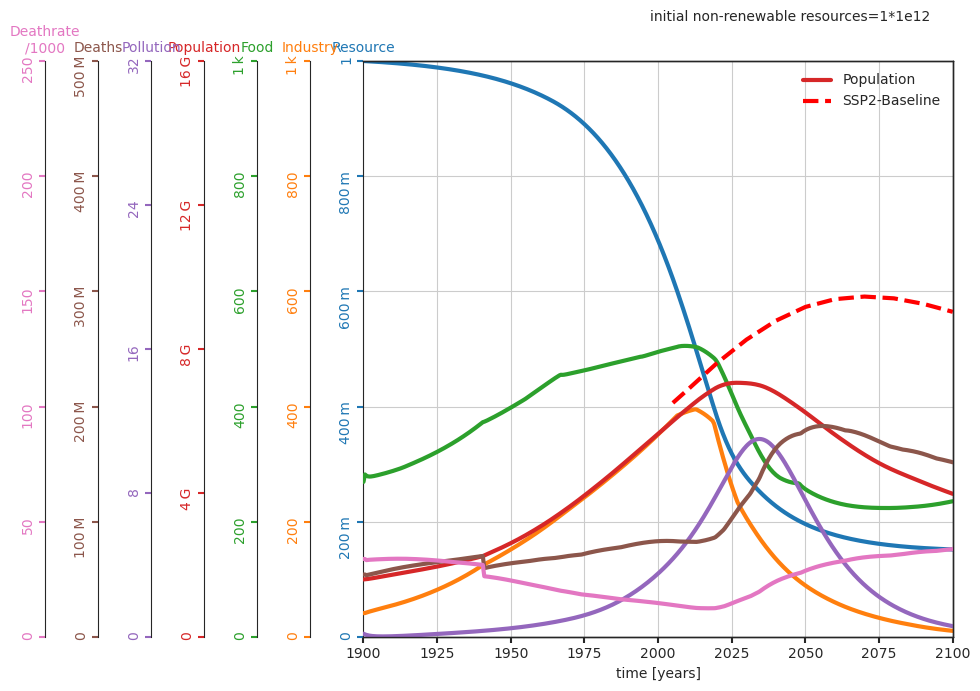

In [9]:
world3 = World3(year_max=maxyear) #default value for nri_factor is 1
run_and_plot(world3)
# plt.savefig("world3_timeseries_case_1.png",transparent=True,bbox_inches="tight",dpi=300)

Initially, industrial production (rising orange), food per capita (rising green) and population (rising red) experience growth. However, as non-renewable resources start rapidly decline (falling blue), industrial production begins to decline (falling orange). This decline subsequently causes a decrease in food production (falling green), which causes an increase in the death rate (rising pink) and a decline in population (falling red) during the latter half of the 21st century. This scenario is resource-constrained because the collapse in growth that occured in the middle of the 21st century was initially driven by a decline in available resources.

For comparison, the red dashed line represents the population projection for the IPCC baseline scenario of SSP2, which reflects a continuation of current trends (effecively their business-as-usual scenario). It is important to note the contrast between the SSP2 projection and the one provided by `World3`.

## **Section 3.2: *BAU3* - An Abundant Resource Scenario**

The previous scenario was resource-constrained, as the collapse in growth was driven by the limited available resources in the middle of the 21st century. In this section you will create a scenario that is not purely resource-constrained by initializing the `pyworld3` with triple the initial non-renewable resources of the *BAU* scenario. As such, let's call this new scenario *BAU3*.

### **Coding Exercise 3.2**

To create the *BAU3* scenario you will need to triple the initial resources (`nri_factor`). Tripling the initial resources could represent the effect of increased efficiency in resource extraction via approaches such as changes in crop yields (as has been observed over recent decades), or the "learning-by-doing" effect that productivity is achieved through practice and innovations (as seen in the economics of many energy technologies). 

**Based on the input parameters of the `run_and_plot()` function discussed above, run the *BAU3* scenario and plot the output.** 

In [5]:
#################################################
# Students: Fill in missing code (...) and comment or remove the next line
raise NotImplementedError("Student exercise: Based on the input parameters of the `run_and_plot()` function discussed above, run the BAU3 scenario and plot the output.")
#################################################

run_and_plot(world3, nri_factor=3)
# plt.savefig("world3_timeseries_case_2.png",transparent=True,bbox_inches="tight",dpi=300)

NotImplementedError: Student exercise: Based on the input parameters of the `run_and_plot()` function discussed above, run the BAU3 scenario and plot the output.

/srv/conda/envs/notebook/lib/python3.10/site-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


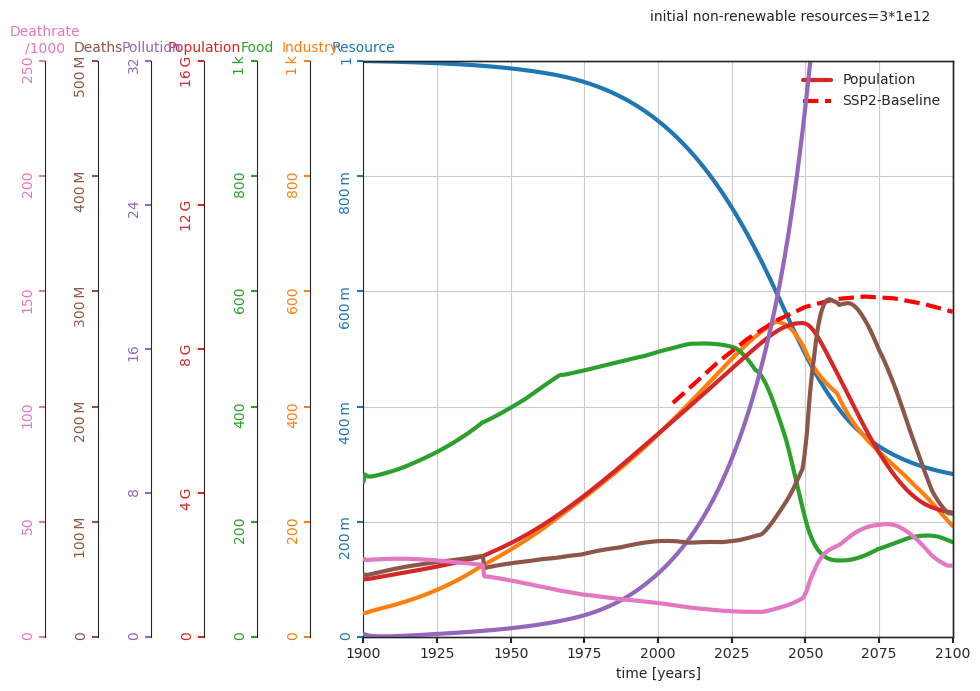

In [10]:
# to_remove solution

run_and_plot(world3, nri_factor=3)
# plt.savefig("world3_timeseries_case_2.png",transparent=True,bbox_inches="tight",dpi=300)

Notice that the decline in industrial production (orange) still occurs in this scenario, but it is delayed by a few decades due to the larger initial resource pool (blue). However, unlike the previous case that was resource-constrained, the extended period of exponential industrial growth (orange) in this scenario leads to a significant increase in pollution (purple). As a result, the population crash (red), which is now driven by both increased pollution (purple) and diminishing resources (blue), is faster and more substantial than the *BAU* scenario's population crash.

In this BAU3 scenario, the population growth and crash more closely resembles the population projection for the IPCC baseline scenario of SSP2 than the BAU scenario, but there is still a contrast between the two population projections. 

## **Section 3.3: *BAU3* with an Active Cap on Production**

In the BAU and BAU3 scenarios, we assessed the impact of changes in initial resource availability (`nri_factor`). However, another important variable to consider is the lifetime of industrial capital (`new_lifetime_industrial_capital`). Economic growth is likely to result in increaesd energy demand, but it's essential to find a way to avoid high levels of climate warming while also meeting the growing world energy demands. To do so would require rapidly transforming current capital infrastructure in our energy system so that it relies on technologies that produce significantly less greenhouse gas emissions. For further details of IAM transitioning with reductions in lifetime capital see [Rozenberg et al. *Environ. Res. Lett.* (2015)](https://iopscience.iop.org/article/10.1088/1748-9326/10/9/095006/pdf).

In this section, you will assess the effects of reducing the lifetime of industrial capital. We will use the same BAU3 scenario with triple the initial resources, but will adjust the `new_lifetime_industrial_capital` variable to reflect a reduced lifetime of industrial capital. Specifically, this scenario turn down production abruptly via a step decrease in the lifetime of industrial capital, by imposing a reduction from 14 to 8 years in 2025.

/srv/conda/envs/notebook/lib/python3.10/site-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


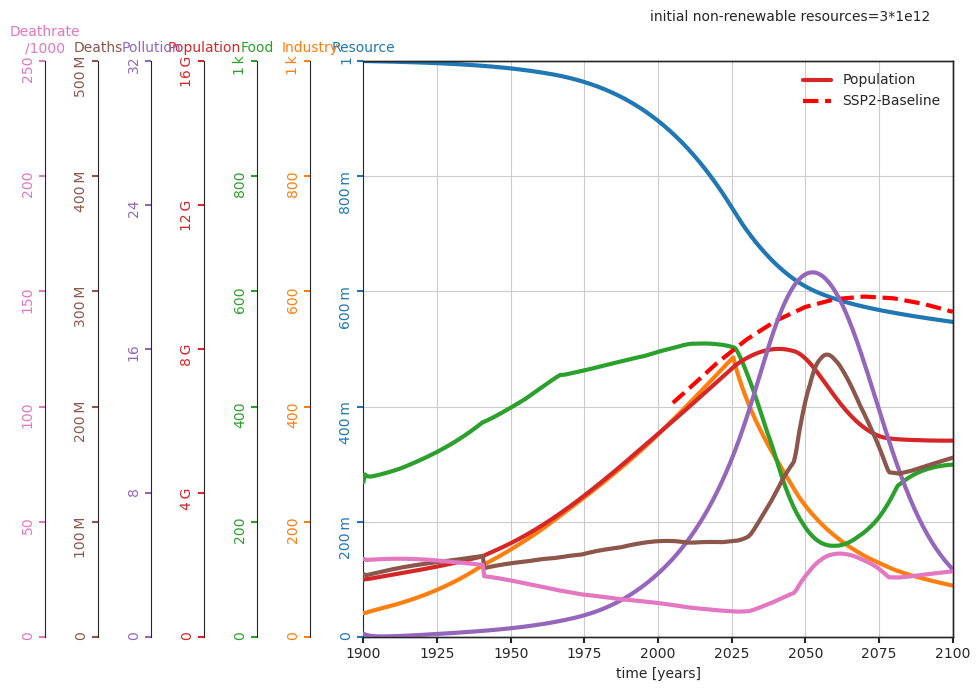

In [11]:
world3 = World3(pyear=2025, year_max=2100)
run_and_plot(world3, nri_factor=3, new_lifetime_industrial_capital=8)
# plt.savefig("world3_timeseries_case_3.png",transparent=True,bbox_inches="tight",dpi=300)

Notice that by reducing production (orange), pollution levels are also reduced (purple), which in turn limits the decline in population to a plateau (red). This approach preserves a significant amount of non-renewable resource (blue), such as ecosystems. However, over time, the asymptotic death rate (pink) gradually increases, approaching that of the BAU3 scenario without the reduced production. As a result, the population plateau is not sustained, and the population continues to decline slowly beyond the year 2100.

Additionally, dropping industrial output (as we did in this scenario) negatively impacts our ability to develop new technologies, e.g. those needed for decarbonization (c.f. the article [Decarbonizing the downturn: Addressing climate change in an age of stagnation by Copley, 2022](https://journals.sagepub.com/doi/full/10.1177/10245294221120986). This stagnation scenario is a central challenge faced in the narrative of Shared Socio-economic Pathway 3 (SSP3 *Regional Rivary*).

### **Questions 3.3:**
1. What scenarios might lead to a drop in the lifetime of industrial capital?
2. What are some important features of the world, society, and/or economy that are missing in this model?

In [ ]:
# to_remove explanation

"""
1. Some examples are environmental degradation, economic instability (e.g., recessions and downturns), and conflicts or disasters (e.g., war and natural disasters)
2. Important features that are missing: e.g., technological innovation; government policies & regulations; education and health services, etc.). Some additional model limitations are listed in the next cell.
"""

## **Section 3.4: Validity and Limitations of `pyworld3`**

Validity analyses for `pyworld3` are presented in the `pyworld3` github repository. For example, shown below is the `pyworld3` standard run simulation output (shown in the same colors we've been using throughout this tutorial) compared to the original World3 model output (shown in black):

In [ ]:
display(Image(url="https://github.com/cvanwynsberghe/pyworld3/raw/main/img/result_standard_run.png", width=250))

Overall, the `pyworld3` simulation output compares well with the original World3 simulation.

However, there are also some additional limitations to the `pyworld3` model that are important to consider including:

- There is no spatial structure. Spatial structure is important, as it allows for distinct regional solutions that aid or hinder global cooperation
- The modelgnores technology innovation, including innovations in adaptation and mitigation
- There is an *ad hoc* relationship between economic growth, investment in health services, and changes in life expectancy
- The model only includes a monolithic non-renewable resource (e.g. doesn't break down the resource into renewable and non-renewable classes)

# **Summary**
In this tutorial, you explored the interplay between climate and socio-economic models, which form the bedrock for the IAMs used in IPCC projections. 

You examined this interplay through `World3`, a *World model* which is a class of model similar to IAMs. You followed several variable dependency pathways within this model to identify some positive and negative feedback loops, and then you used this model to simulate 3 future scenarios which varied in their amount of initially available non-renewable resources and the lifetime of capital. Through these simulations you explored the factors driving current population growth, and its future projected decline or stabilization. In particular, you found rapid resource consumption can have negative impacts by exhausting these resources and/or by increasing pollution and reducing human health, thus highlighting the potential threats of unregulated resource extraction on a finite planet.

Finally, you learned about some of the limitations of models like `World3`, as they don't include some important natural and socio-economic variables. By exploring these complex concepts, you are now better equipped to engage with discussions on climate change, resource management, and sustainable economic growth.

# **Resources**

The data for the IAMs used in this tutorial, as well as the main simulations of the IAMs used in the IPCC reports can be accessed h[here](https://tntcat.iiasa.ac.at/SspDb/dsd). 

The `pyworld3` model and data used in this tutorial can be accessed [here](https://github.com/cvanwynsberghe/pyworld3).